In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_row', 100)
pd.set_option('display.max_info_columns', 100)


    - Datafield
    - DBNOs(Down But Not Out)   적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
    - assists                   아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
    - boosts                    부스트 아이템 사용 횟수
    - damageDealt               총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
    - headshotKills             헤드샷 킬 수
    - heals                     힐링 아이템 사용 횟수
    - Id                        플레이어 ID
    - killPlace                 매치에서의 킬수만 따졋을때 순위
    - killPoints                킬 수로 산정한 ELO의 개념. rankpoints가 없다면 killPoints가 존재 
    - killStreaks               짧은 시간동안 최대한 많이 킬했을 때의 킬 수 / 죽지않고 킬을 했을때 
    - kills                     총 킬 수
    - longestKill               킬과 킬 사이의 이동한 가장 긴 거리
    - matchDuration             매치의 시간 (초 단위)   -> 맵 사이즈에 따른 시간이 다르다 (평균 : 30분, 23분 )
    - matchId                   매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
    - matchType                 매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 
                                나머지는 이벤트 또는 커스텀 매치
    - rankPoints                랭킹 ELO의 개념
    - revives                   아군 부활 횟수
    - rideDistance              탈것으로 이동한 총 거리
    - roadKills                 탈것으로 킬한 횟수
    - swimDistance              수영한 총 거리
    - teamKills                 팀킬 횟수
    - vehicleDestroys           차량 폭파 횟수
    - walkDistance              걸어간 총 거리 total : 3 map 
                                -> map 2개 : 8 X 8 km => 최대 대각선 길이 : 11.3km
                                   map 1개 : 4 X 4 km => 최대 대각선 길이 : 5.6km
    - weaponsAcquired           얻은 무기의 수
    - winPoints                 승리 횟수로 판단한 ELO의 개념
    - groupId                   매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 
                                새로운 그룹 아이디가 부여됨
    - numGroups                 게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)
    - maxPlace                  한 경기내 최하 등수()
    - winPlacePerc              예측 목표, 1에 가까워질 수록 순위가 높아진다. 
                                (0부터 1까지의 값으로 나타냄. 1은 1등을, 0은 꼴등을 의미한다.)
                                (maxPlace-winPlace)/(maxPlace-1) = winPlacePerc
                                즉, 경기에 들어온 팀수에 따라 경기 등수가 결정된다.

## 사전 지식 전달 사항

- 기본 게임 진행 방식 : 

- 우승 조건 :

- 기타 : 

## 기본 사항

In [2]:
# 이벤트 메치 드랍된 자료 사용
data_path = 'C:/Users/hojun/Documents/dev/Kaggle-PUBG/'
df = pd.read_csv(data_path+'event_drop.csv')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
# df = reduce_mem_usage(df)

## drop

In [5]:
# drop 확인을 위한 DataFrame 생성
drop_proof_df = df.copy()

### drop event game 

In [6]:
# drop_event = ['crashfpp', 'flaretpp', 'flarefpp', 'crashtpp']
# for i in drop_event:
#     indexNames = df[df['matchType'].str.contains(i)].index
#     df.drop(indexNames,  inplace=True)


#### 이유

전체 데이터의 0.1%도 차지하지 않는 데이터양과 이상치, 특이한 방식의 게임 운영으로 이벤트 경기는 제외

### drop columns

#### 'killPoints', 'winPoints', 'rankPoints' drop

In [7]:
drop_columns = ['killPoints', 'winPoints', 'rankPoints']
df.drop(columns=drop_columns, inplace=True)

##### 이유 

'killPoints', 'winPoints', 'rankPoints' 상관관계도로 확인

결과에 의한 수치들을 계산한 값으로써 너무 높은 영향(leakage)를 확인하여 제외

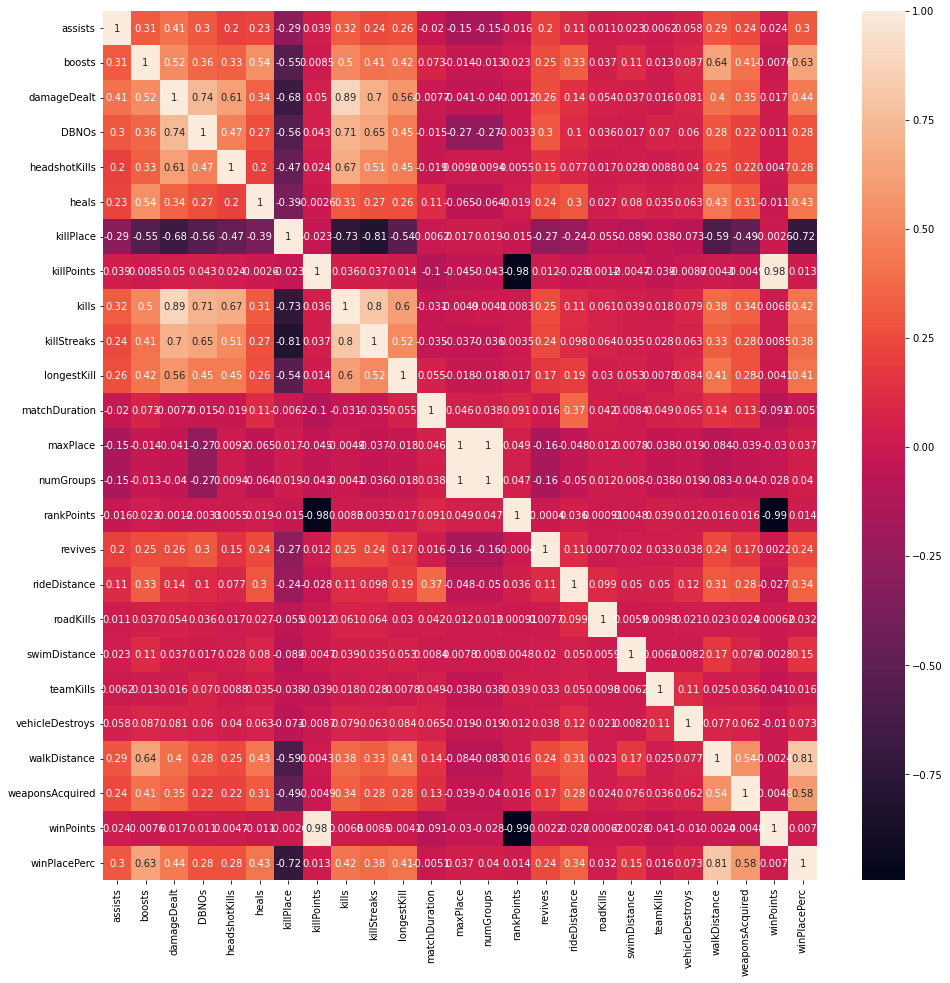

In [8]:
plt.figure(figsize=(16, 16))
sns.heatmap(data=drop_proof_df.corr(), annot=True)
plt.show()

#### 'numGroups' drop

In [9]:
df.drop(columns='numGroups', inplace=True)

##### 이유

- 예측값 : 1 (1등)의 이동 거리 분포 확인

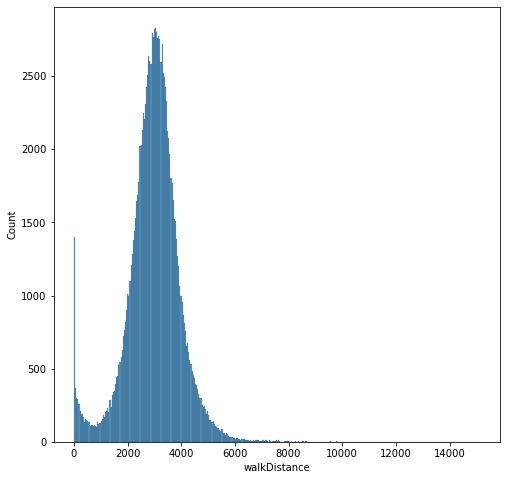

In [10]:
wpp_1 =drop_proof_df[drop_proof_df['winPlacePerc'] == 1]['walkDistance']
plt.figure(figsize=(8, 8))
sns.histplot(data=drop_proof_df, x=wpp_1 )
plt.show()

- 1등인데 이동거리가 0인 data 확인

In [11]:
drop_proof_df[(drop_proof_df['winPlacePerc'] == 1) & (drop_proof_df['walkDistance']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3692,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,1,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0
8770,106afdb574db25,4b0ae4659e9936,cf0cb51c829eb5,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,1,0,1.0
9243,0351565a7058e9,3663a93a319725,3659fe3694262a,0,0,0.3218,0,0,0,1,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
18378,e6d6f94558dd2f,22818b9a9a6159,486200c5613f14,0,1,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,19,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
19006,d0683f5d780f09,faebf5c484de4a,ec9a90395ed8c0,0,0,99.0000,0,0,0,1,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419845,6cc9d7b1643cbd,11fce60d5c8ea3,60c6e90b964266,3,0,645.6000,6,1,0,28,0,5,2,57.58,1216,normal-squad-fpp,6,6,1500,2,0.0,0,0.0,0,0,0.0,31,0,1.0
4420599,69f2d577afb916,1ca82eb3229fe3,8b1af8b54b0edb,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,0,0,1.0
4422414,87a4d46be07ec6,7921c8beb38c2d,2183f03b8dd456,0,3,115.6000,0,0,1,2,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
4433367,120b7d2d32663f,b70109a45eb127,6db87452a2db21,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0


In [12]:
drop_proof_df[drop_proof_df['matchId']=='01aead02bb8901'][['groupId', 'damageDealt', 'kills', 'killPlace', 'matchType','maxPlace','numGroups','walkDistance','weaponsAcquired','winPlacePerc']]

,groupId,damageDealt,kills,killPlace,matchType,maxPlace,numGroups,walkDistance,weaponsAcquired,winPlacePerc
3692,5cef1df7ee3551,0.00,0,1,solo,20,2,0.0,3,1.0
52397,c70fd467685d53,178.50,0,16,solo,20,2,0.0,3,0.0
152554,5cef1df7ee3551,0.00,0,4,solo,20,2,592.9,5,1.0
230675,c70fd467685d53,0.00,0,11,solo,20,2,0.0,3,0.0
312980,5cef1df7ee3551,119.40,0,3,solo,20,2,0.0,8,1.0
449983,c70fd467685d53,78.00,0,10,solo,20,2,0.0,3,0.0
762729,c70fd467685d53,0.00,0,20,solo,20,2,0.0,0,0.0
1319387,c70fd467685d53,0.00,0,18,solo,20,2,0.0,7,0.0
1688326,c70fd467685d53,159.00,0,9,solo,20,2,0.0,5,0.0
1839645,5cef1df7ee3551,0.00,0,2,solo,20,2,0.0,3,1.0


    - 수치상 불가능한 data (이동거리 없이 무기획득 등) 확인  되어 제외

- maxPlace(경기당 마지막 등수)와 numGroups(경기 참가팀수)가 다른 경기들 확인

In [13]:
temp_df = drop_proof_df[drop_proof_df.maxPlace != drop_proof_df.numGroups].sort_values(by=['numGroups','matchId'])[['winPlacePerc', 'numGroups', 'maxPlace', 'matchId']]
temp_df 

,winPlacePerc,numGroups,maxPlace,matchId
337842,0.0000,1,18,07baf6b1ba3de9
671026,0.0000,1,18,07baf6b1ba3de9
1056287,0.0000,1,18,07baf6b1ba3de9
1664753,0.0000,1,18,07baf6b1ba3de9
2046163,0.0000,1,18,07baf6b1ba3de9
...,...,...,...,...
4291031,0.5455,99,100,fe1be8e33af055
4295868,0.1717,99,100,fe1be8e33af055
4334803,0.3737,99,100,fe1be8e33af055
4370186,0.7980,99,100,fe1be8e33af055


- numGroups : 1 인 경우 예측값이 0으로 된다.

    -> numGroups : 1 인 경우 제외


In [14]:
temp_df.head(18)

,winPlacePerc,numGroups,maxPlace,matchId
337842,0.0,1,18,07baf6b1ba3de9
671026,0.0,1,18,07baf6b1ba3de9
1056287,0.0,1,18,07baf6b1ba3de9
1664753,0.0,1,18,07baf6b1ba3de9
2046163,0.0,1,18,07baf6b1ba3de9
2220777,0.0,1,18,07baf6b1ba3de9
2273755,0.0,1,18,07baf6b1ba3de9
2318787,0.0,1,18,07baf6b1ba3de9
2394697,0.0,1,18,07baf6b1ba3de9
2494260,0.0,1,18,07baf6b1ba3de9


In [15]:
temp_df[temp_df['numGroups']==1]['winPlacePerc'].unique()

array([0.])

numGroups과 maxPlace가 일치하지 않는 경우 확인

- maxPlace : 3 이하인 경우는 없었고

- maxPlace의 value와 winPlacePerc(예측값)의 분할갯수가 일치하였고 

    -> numGroups는 일치하지 않는 경우가 있어서 numGroups는 제외

In [16]:
temp_df[temp_df['maxPlace'] <=3]

,winPlacePerc,numGroups,maxPlace,matchId


In [17]:
temp_df[temp_df['numGroups']==5]['winPlacePerc'].unique()

array([0.8   , 0.6   , 0.2   , 1.    , 0.    , 0.4   , 0.625 , 0.25  ,
       0.5   , 0.7143, 0.4286, 0.1429, 0.8333, 0.3333])

In [18]:
temp = []
for i in range(4, 101):
    temp.append([i, temp_df[temp_df['maxPlace']==i]['winPlacePerc'].nunique()])
print(temp)

[[4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 44], [54, 54], [55, 55], [56, 55], [57, 57], [58, 57], [59, 52], [60, 60], [61, 60], [62, 62], [63, 50], [64, 64], [65, 65], [66, 66], [67, 64], [68, 68], [69, 69], [70, 70], [71, 71], [72, 69], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99], [100, 100]]


In [19]:
# 확인용 DataFrame 삭제
del temp_df
del drop_proof_df
gc.collect()

24253

### drop isna True

- 예측값 결측치가 있는 경기 drop

In [20]:
df[df['winPlacePerc'].isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
2738537,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0.0,9,solo-fpp,1,0,0.0,0,0.0,0,0,0.0,0,NaN


In [21]:
df.drop(index=df[df['matchId']== '224a123c53e008'].index, inplace=True)

### drop 경기인원 이하 (custom game) - 추가 가능 좀비모드 그래프 추가

#### 이유

- 경기 인원이 일정 이하인 경우 : 이동거리, 무기획득이 너무 높은 수치가 나와서 결과값 예측에 방해가 된다.

In [22]:
df[(df.maxPlace <= 5) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

,weaponsAcquired,walkDistance,winPlacePerc,maxPlace
20333,3,3033.0,0.0,4
22365,6,841.4,0.0,4
33176,12,0.0,0.0,2
41148,17,2400.0,0.0,3
51253,2,129.3,0.0,2
...,...,...,...,...
4426104,17,614.2,0.0,5
4428841,22,784.4,0.0,3
4431020,8,0.0,0.0,2
4431219,13,186.6,0.0,2


In [23]:
df[df.maxPlace <= 5]['matchType'].value_counts()

normal-squad-fpp    1319
normal-duo-fpp       211
normal-squad         138
squad-fpp             65
normal-duo            20
duo-fpp               15
normal-solo-fpp       10
Name: matchType, dtype: int64

- 대부분이 normal 경기이고 해당 수치와 normal 경기에서 발견되는 각종 이상치들 확인
- 전체 경기 중 차지 비율이 낮으므로 제외

    - normal 경기 제외

In [24]:
df = df.drop(index=df[df['matchType'].str.contains('normal')].index)

In [25]:
df[(df.maxPlace >= 6) &(df.maxPlace <= 10) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

,weaponsAcquired,walkDistance,winPlacePerc,maxPlace
254298,1,118.600,0.0,7
283360,3,533.800,0.0,8
378858,0,0.000,0.0,10
398634,1,36.290,0.0,10
653482,2,35.390,0.0,7
680701,3,57.320,0.0,10
1005322,0,0.000,0.0,10
1061705,1,30.520,0.0,10
1123819,0,29.870,0.0,7
1219599,2,26.890,0.0,10


## 핵 사용 유저 선별 및 제거 함수 

In [26]:
def hack_user_drop(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    ### Anomalies in aim 1 (More than 50 kills) ###
    df.drop(df[df['kills'] >= 40].index, inplace=True)
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    df.drop(df[df['headshotKills'] >= 15].index, inplace=True)
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    df.drop(df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)].index , inplace=True)
    ### Anomalies in aim 3 (Longest kill) ###
    df.drop(df[df['longestKill'] >= 1000].index, inplace=True)
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    df.drop(df[df['DBNOs'] >= 20].index, inplace=True)
    ### Anomalies in movement ###
    # walkDistance anomalies
    df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
    # rideDistance anomalies
    df.drop(df[df['rideDistance'] >= 25000].index, inplace=True)
    # swimDistance anomalies
    df.drop(df[df['swimDistance'] >= 1500].index, inplace=True)
    ### Anomalies in item 1 (weaponsAcquired) ###
    df.drop(df[df['weaponsAcquired'] >= 50].index, inplace=True)
    ### Anomalies in item 2 (heals) ###
    df.drop(df[df['heals'] >= 40].index, inplace=True)
    ### Anomalies in item 3 (boosts) ###
    df.drop(df[df['boosts'] >= 15].index, inplace=True)
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    df.drop(df[df['killStreaks'] >= 10].index ,inplace=True)
    # revive zombies (revives >= 10)
    df.drop(df[df['revives'] >= 10].index ,inplace=True)
    #Weapon master (weaponsAcquired >= 50)
    df.drop(df[df['weaponsAcquired'] >= 50].index ,inplace=True)
    #team killer = troll ( teamkills > 4)
    df.drop(df[df['teamKills'] >= 50].index ,inplace=True)
    # Strange road killer (roadKills>= 5)
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    # Too little walkDistance
    df.drop(df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)].index, inplace=True)
    # superman ?
    df.drop(df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)].index, inplace=True)
    # Maybe cheater & Gosu
    df.drop(df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)].index, inplace=True)
    return df

In [27]:

def hack_users(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    ### Anomalies in aim 1 (More than 50 kills) ###
    hack_users = pd.concat([hack_users, df[df['kills'] >= 40]])
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    hack_users = pd.concat([hack_users, df[df['headshotKills'] >= 15]])
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    hack_users = pd.concat([hack_users, df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)]])
    ### Anomalies in aim 3 (Longest kill) ###
    hack_users = pd.concat([hack_users, df[df['longestKill'] >= 1000]])
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    hack_users = pd.concat([hack_users, df[df['DBNOs'] >= 20]])
    ### Anomalies in movement ###
    # walkDistance anomalies
    hack_users = pd.concat([hack_users, df[df['walkDistance'] >= 10000]])
    # rideDistance anomalies
    hack_users = pd.concat([hack_users, df[df['rideDistance'] >= 25000]])
    # swimDistance anomalies
    hack_users = pd.concat([hack_users, df[df['swimDistance'] >= 1500]])
    ### Anomalies in item 1 (weaponsAcquired) ###
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    ### Anomalies in item 2 (heals) ###
    hack_users = pd.concat([hack_users, df[df['heals'] >= 40]])
    ### Anomalies in item 3 (boosts) ###
    hack_users = pd.concat([hack_users, df[df['boosts'] >= 15]])
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    hack_users = pd.concat([hack_users, df[df['killStreaks'] >= 10]])
    # revive zombies (revives >= 10)
    hack_users = pd.concat([hack_users, df[df['revives'] >= 10]])
    #Weapon master (weaponsAcquired >= 50)
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    #team killer.append(troll ( teamkills > 4)
    hack_users = pd.concat([hack_users, df[df['teamKills'] >= 50]])
    # Strange road killer (roadKills>= 5)
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    # Too little walkDistance
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)]])
    # superman ?
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)]])
    # Maybe cheater & Gosu
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)]])
    return hack_users

## 핵 유저 관련 feature 생성

In [28]:
# hack_user_drop(df)
# df.drop(columns='headshot_rate', inplace=True)

- 핵사용 유저 확인 (핵 중복 사용 유저 정리 포함)

In [29]:
hack_user = hack_users(df)
df.drop(columns='headshot_rate', inplace=True)
hack_user.drop(columns='headshot_rate', inplace=True)
hack_user = hack_user.drop_duplicates('Id') # 핵 중복 사용 유저 정리

In [30]:
hack_fuature_add_df = df.copy()

- 핵유저 포함 team 표시 feature 생성

In [31]:
hack_user_groupid = str(list(hack_user.groupId.values))

# -> 핵유저가 있는 팀 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_team"] = hack_fuature_add_df.groupId.apply(lambda x : 0 if hack_user_groupid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

- 핵유저 참여 game 표시 feature 생성

In [32]:
hack_user_matchid = str(list(hack_user.matchId.values))

# -> 핵유저가 참여한 경기 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_game"] = hack_fuature_add_df.matchId.apply(lambda x : 0 if hack_user_matchid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

In [33]:
# 핵유저 제거 확인
# set(list(hack_user['groupId'])) & set(list(hack_team_drop[hack_team_drop['hack_user_team']==0]['groupId']))

In [34]:
# 핵 유저가 참여한 경기 수
hack_game_count = round(hack_fuature_add_df.groupby('matchId')['hack_user_game'].agg(np.mean).sum())

print('핵유저수 :', hack_user.index.size, '\t\t\t',  '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_user.index.size/df.index.size*100), 3))
print('핵유저 포함 팀수 :', len(set(list(hack_user['groupId']))), '\t\t', '전체 참가팀수 :', len(set(list(df['groupId']))), '\t', '비율 :',round( len(set(list(hack_user['groupId'])))/len(set(list(df['groupId'])))*100 ,3))
print('핵유저팀 포함된 인원수 :', hack_fuature_add_df['hack_user_team'].sum(), '\t', '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_fuature_add_df['hack_user_team'].sum()/df.index.size*100), 3))
print('핵유저팀 포함된 경기수 :',hack_game_count,'\t', '전체 경기수 :', df.matchId.nunique(), '\t\t','비율 :', round((hack_game_count/df.matchId.nunique()*100), 3))

핵유저수 : 1810 			 전체 참가인원 : 4411698 	 비율 : 0.041
핵유저 포함 팀수 : 1343 		 전체 참가팀수 : 2014090 	 비율 : 0.067
핵유저팀 포함된 인원수 : 3419 	 전체 참가인원 : 4411698 	 비율 : 0.077
핵유저팀 포함된 경기수 : 1305 	 전체 경기수 : 47185 		 비율 : 2.766


### 핵유저가 포함된 경기들에서 핵유저가 거둔 성적 정리

In [35]:
# 핵유저가 포함된 팀과 경기
hack_team_include_team = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 1]
hack_team_include_game = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 1]

- 핵유저 포함 팀 또는 개인의 성적 확인 (우승 빈도, 전체 평균 성적)


In [36]:
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
hack_win_count

1005

In [37]:
hack_game_count

1305

In [38]:
# 핵유저 개인 or 팀 우승 빈도
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
print('핵유저 우승 횟수:', hack_win_count ,'\t\t', '핵유저 참여 경기수:', hack_game_count, '\t', '우승 확률 :', round(hack_win_count/hack_game_count*100, 3))

# 핵유저 개인 or 팀 평균 등수
hack_team_no_include = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 0]
print('핵유저팀 평균 등수 :', round(hack_team_include_team.winPlacePerc.values.mean(), 3), '\t', '일반 유저팀 평균 등수', round(hack_team_no_include.winPlacePerc.values.mean(), 3))
print('핵유저 평균 등수 :', round(hack_user.winPlacePerc.values.mean(), 3), '\t', '일반 평균 등수 :', round(hack_fuature_add_df.winPlacePerc.values.mean(), 3))


핵유저 우승 횟수: 1005 		 핵유저 참여 경기수: 1305 	 우승 확률 : 77.011
핵유저팀 평균 등수 : 0.771 	 일반 유저팀 평균 등수 0.472
핵유저 평균 등수 : 0.891 	 일반 평균 등수 : 0.473


In [39]:
# 팀별 평균 예상 : 0.5  실제 값 : 0.4998  
# hack_fuature_add_df.groupby('groupId')['winPlacePerc'].agg(np.mean).values.mean()

- 핵유저의 우승 확률이 77% 가 넘는 수치가 나옴
- 핵유저를 포함한 팀은 성적 상승
- 핵유저는 평균 등수 상승 
- 핵유저가 참석한 경기 -> 공정한 경기로 보기 어려움

#### 결과 : 핵유저가 참석한 경기와 같은 팀들의 상황을 분석하고 해당 경기 제외


## 핵유저가 없는 공평한 경기가 이루어졌을때를 전제로 프로젝트를 수행

In [40]:
hack_fuature_add_df = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 0]

## data 분석을 위해 match type으로 data 분리

### 팀킬, 부활 등 팀원이 존재해야 되는 feature들이 있어서 match type에 따라 분리

- categorical - nominal data => numerical
    - solo : 0, duo : 1, squad : 2

In [41]:
def divide_match_type(x):
    if x.find('solo') != -1:
        return 0
    elif x.find('duo') != -1:
        return 1
    else:
        return 2
hack_fuature_add_df['match_type_numerical'] = hack_fuature_add_df['matchType'].apply(lambda x : divide_match_type(x) )

In [42]:
hack_fuature_add_df[['matchType', 'match_type_numerical']].tail()

,matchType,match_type_numerical
4437079,squad-fpp,2
4437080,squad-fpp,2
4437081,solo,0
4437082,squad-fpp,2
4437084,solo-fpp,0


In [44]:
# hack_fuature_add_df.to_csv(data_path+'hack_fuature_add_df.csv')
# hack_fuature_add_df = pd.read_csv(data_path+'hack_fuature_add_df.csv')

# Duo, Squad EDA

#### team data에 팀별로 groupby 하여 팀원수 column 추가

In [45]:
hack_fuature_add_df['team_members'] = hack_fuature_add_df.groupby('groupId').Id.transform('count')

- 일부 feature는 합계로 나머지는 평균 feature를 정리

In [50]:
team_df_sum = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0].iloc[:, :-5].groupby(['matchId', 'groupId']).agg(sum)
team_df_mean = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0][['matchId', 'groupId','winPlacePerc', 'team_members', 'match_type_numerical', 'hack_user_team', 'hack_user_game']].groupby(['matchId', 'groupId']).agg(np.mean)

team_df = pd.concat([team_df_sum, team_df_mean], axis=1, ignore_index=False)

team_df = team_df[team_df['match_type_numerical'] != 0]

In [52]:
team_df

assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0000a43bce5eec 18b16ec699d8b6        0       1       219.35      2   
               236ab9e9c081b9        0       0       287.93      2   
               3a6addfa0df938        0       0         0.00      0   
               4bf06994bd4c9a        0       1        23.40      0   
               4d1bbbc19b9084        2       7       681.90      5   
...                                ...     ...          ...    ...   
fffe92232706aa b671eab579d429        0       0        16.95      0   
               bd5b4ecf8067ab        2       8       617.03      4   
               c8e95cc6c06d41        0       0       155.70      1   
               d57f3a3ed40913        0       2       239.00      3   
               d8fa9cfd6f9560        1       9       730.90      4   

                               headshotKills  heals  killPlace  kills  \
matchId        groupId                                                  
0000a43bce5eec 18b16ec699d8b6              0      1         82      2   
               236ab9e9c081b9              0      0        543      0   
               3a6addfa0df938              0      0        189      0   
               4bf06994bd4c9a              0      0        119      0   
               4d1bbbc19b9084              2      2         28      6   
...                                      ...    ...        ...    ...   
fffe92232706aa b671eab579d429              0      0         29      1   
               bd5b4ecf8067ab              2     20         58      4   
               c8e95cc6c06d41              0      0        492      1   
               d57f3a3ed40913              0      2        243      1   
               d8fa9cfd6f9560              4     13        294      4   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0000a43bce5eec 18b16ec699d8b6            1       12.550           2692   
               236ab9e9c081b9            0        0.000           8076   
               3a6addfa0df938            0        0.000           2692   
               4bf06994bd4c9a            0        0.000           2692   
               4d1bbbc19b9084            3       50.460           2692   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429            1       32.990           1863   
               bd5b4ecf8067ab            3      348.313           5589   
               c8e95cc6c06d41            1        8.009          11178   
               d57f3a3ed40913            1        2.177           7452   
               d8fa9cfd6f9560            3      153.259          13041   

                               maxPlace  revives  rideDistance  roadKills  \
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6        56        0         0.000          0   
               236ab9e9c081b9       168        0         0.000          0   
               3a6addfa0df938        56        0         0.000          0   
               4bf06994bd4c9a        56        0         0.000          0   
               4d1bbbc19b9084        56        0       159.906          0   
...                                 ...      ...           ...        ...   
fffe92232706aa b671eab579d429        29        0      1732.000          0   
               bd5b4ecf8067ab        87        4     12903.000          1   
               c8e95cc6c06d41       174        0         0.000          0   
               d57f3a3ed40913       116        0         0.000          0   
               d8fa9cfd6f9560       203        2      5919.700          0   

                               swimDistance  teamKills  vehicleDestroys  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6         0.000          0 

#### team member를  game type별로 각 수치를 정규화

- duo, squad -> 1명 기준 (수치 / 팀원수)

In [54]:
# duo 경기 정규화
temp_duo = team_df[team_df.match_type_numerical ==1].copy()

for i in range(len(team_df.columns.values)-5):
    temp_duo.iloc[:, i] = (temp_duo.iloc[:, i]/temp_duo.iloc[:, -4])

# squad 경기 정규화
temp_squad = team_df[team_df.match_type_numerical ==2].copy()
for i in range(len(team_df.columns.values)-5):
    temp_squad.iloc[:, i] = (temp_squad.iloc[:, i]/temp_squad.iloc[:, -4])


In [55]:
team_df = pd.concat([temp_duo, temp_squad], axis=0, ignore_index=False)
del temp_duo
del temp_squad
gc.collect()

1614

In [56]:
team_df

assists    boosts  damageDealt     DBNOs  \
matchId        groupId                                                     
0003b92987589e 024136db14272c  0.500000  0.000000    11.700000  0.000000   
               058b63035c6c08  0.000000  2.500000   138.500000  1.000000   
               0c7fbc2742917b  0.500000  1.500000   277.800000  1.000000   
               1add3b8ce32302  0.000000  2.000000   223.060000  1.500000   
               1ed2da8e6c07b5  0.000000  1.000000    72.600000  0.000000   
...                                 ...       ...          ...       ...   
fffe92232706aa b671eab579d429  0.000000  0.000000    16.950000  0.000000   
               bd5b4ecf8067ab  0.666667  2.666667   205.676667  1.333333   
               c8e95cc6c06d41  0.000000  0.000000    25.950000  0.166667   
               d57f3a3ed40913  0.000000  0.500000    59.750000  0.750000   
               d8fa9cfd6f9560  0.142857  1.285714   104.414286  0.571429   

                               headshotKills     heals  killPlace     kills  \
matchId        groupId                                                        
0003b92987589e 024136db14272c       0.000000  0.000000  75.500000  0.000000   
               058b63035c6c08       1.000000  3.000000  27.000000  1.500000   
               0c7fbc2742917b       0.500000  2.500000  15.000000  2.500000   
               1add3b8ce32302       0.000000  1.500000  25.500000  2.000000   
               1ed2da8e6c07b5       0.000000  4.000000  46.000000  0.500000   
...                                      ...       ...        ...       ...   
fffe92232706aa b671eab579d429       0.000000  0.000000  29.000000  1.000000   
               bd5b4ecf8067ab       0.666667  6.666667  19.333333  1.333333   
               c8e95cc6c06d41       0.000000  0.000000  82.000000  0.166667   
               d57f3a3ed40913       0.000000  0.500000  60.750000  0.250000   
               d8fa9cfd6f9560       0.571429  1.857143  42.000000  0.571429   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0003b92987589e 024136db14272c     0.000000     0.000000         1410.0   
               058b63035c6c08     1.000000    48.030000         1410.0   
               0c7fbc2742917b     1.500000    43.565000         1410.0   
               1add3b8ce32302     1.000000    72.900000         1410.0   
               1ed2da8e6c07b5     0.500000     2.892500         1410.0   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429     1.000000    32.990000         1863.0   
               bd5b4ecf8067ab     1.000000   116.104333         1863.0   
               c8e95cc6c06d41     0.166667     1.334833         1863.0   
               d57f3a3ed40913     0.250000     0.544250         1863.0   
               d8fa9cfd6f9560     0.428571    21.894143         1863.0   

                               maxPlace   revives  rideDistance  roadKills  \
matchId        groupId                                                       
0003b92987589e 024136db14272c      50.0  0.000000      0.000000   0.000000   
               058b63035c6c08      50.0  0.000000    501.500000   0.000000   
               0c7fbc2742917b      50.0  0.000000      0.000000   0.000000   
               1add3b8ce32302      50.0  0.000000      0.000000   0.000000   
               1ed2da8e6c07b5      50.0  0.000000    845.450000   0.000000   
...                                 ...       ...           ...        ...   
fffe92232706aa b671eab579d429      29.0  0.000000   1732.000000   0.000000   
               bd5b4ecf8067ab      29.0  1.333333   4301.000000   0.333333   
               c8e95cc6c06d41      29.0  0.000000      0.000000   0.000000   
               d57f3a3ed40913      29.0  0.000000      0.000000   0.000000   
               d8fa9cfd6f9560      29.0  0.285714    845.671429   0.000000   

                               swimDi

- duo, squad 게임에서 상관관계(원본 데이터 heatmap 비교)

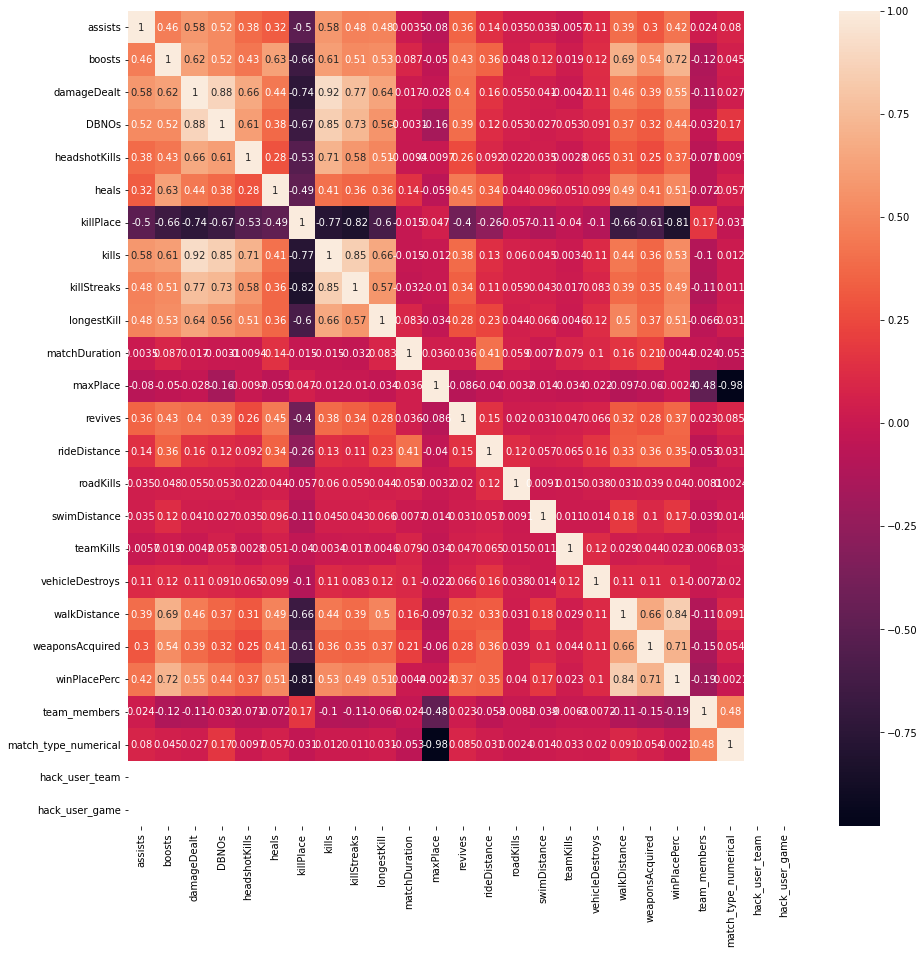

In [57]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=team_df.corr(), annot=True)
plt.show()

'killPoints', 'winPoints', 'rankPoints' columns은 상관관계가 너무 높고 

에측값에 대한 독립 column이 아닌 결과로 나온 계산 값이므로 제외

- 팀별로 모았을때 예측값에 대한 상관관계

In [58]:
temp = pd.concat([team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp.columns = ['winPlacePerc(after)', 'winPlacePerc(before)']
temp

,winPlacePerc(after),winPlacePerc(before)
winPlacePerc,1.000000,1.000000
walkDistance,0.844499,0.814679
boosts,0.716719,0.636463
weaponsAcquired,0.706871,0.617926
damageDealt,0.546226,0.450645
kills,0.527081,0.431588
longestKill,0.512686,0.412435
heals,0.507204,0.430058
killStreaks,0.485215,0.377973
DBNOs,0.435345,0.284162


    - 원본 데이터보다 예측값에 대한 feature들의 상관관계가 더욱 명확해짐

    - walkDistance 아주 높은 상관관계를 확인 할 수 있다
        - 경기에서 오래 살아 남을수록 자기장을 피해 안전 지역으로 이동해야 되므로 
            대체로 이동거리가 늘어난다.(낙하지점과 안전지역이 가까운 경우 제외)

### 데이터 분포에 50%이상이 0 인 feature들의 0인 플레이어들의 winPlacePerc 기준 수치

In [59]:
team_df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,team_members,match_type_numerical,hack_user_team,hack_user_game
count,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06,1299387.0,1299387.0
mean,2.566098e-01,1.211224e+00,1.394426e+02,7.957323e-01,2.356189e-01,1.514811e+00,4.564842e+01,9.755212e-01,5.872758e-01,2.450860e+01,1.577280e+03,3.760003e+01,1.914128e-01,6.565111e+02,2.697372e-03,4.939084e+00,2.633543e-02,8.473561e-03,1.257315e+03,3.792930e+00,5.001981e-01,2.793920e+00,1.517284e+00,0.0,0.0
std,4.507457e-01,1.550401e+00,1.367166e+02,8.662529e-01,4.359968e-01,2.333649e+00,2.340127e+01,1.223257e+00,5.601226e-01,4.102364e+01,2.537090e+02,9.989491e+00,3.420808e-01,1.477718e+03,4.114083e-02,2.805979e+01,1.237418e-01,6.466205e-02,1.159643e+03,1.937892e+00,3.000174e-01,1.485156e+00,4.997014e-01,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.280000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0
25%,0.000000e+00,0.000000e+00,4.946500e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.725000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.365000e+03,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.199500e+02,2.333333e+00,2.391000e-01,2.000000e+00,1.000000e+00,0.0,0.0
50%,0.000000e+00,5.000000e-01,1.000000e+02,5.000000e-01,0.000000e+00,5.000000e-01,4.450000e+01,5.000000e-01,5.000000e-01,7.200000e+00,1.433000e+03,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.234000e+02,3.666667e+00,5.000000e-01,2.000000e+00,2.000000e+00,0.0,0.0
75%,5.000000e-01,2.000000e+00,1.892146e+02,1.000000e+00,3.333333e-01,2.000000e+00,6.250000e+01,1.500000e+00,1.000000e+00,3.086500e+01,1.847000e+03,4.800000e+01,3.333333e-01,4.195750e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.105500e+03,5.000000e+00,7.660000e-01,3.000000e+00,2.000000e+00,0.0,0.0
max,6.666667e+00,1.400000e+01,2.580000e+03,1.800000e+01,1.300000e+01,3.900000e+01,1.000000e+02,2.000000e+01,9.000000e+00,9.605500e+02,2.226000e+03,5.100000e+01,9.000000e+00,2.276000e+04,4.000000e+00,1.304000e+03,4.000000e+00,4.000000e+00,9.969000e+03,3.400000e+01,1.000000e+00,7.200000e+01,2.000000e+00,0.0,0.0


In [60]:
# 함수로 생성
def zeropoint_corr_winPlacePerc(df):
    zero_point_list = ['assists', 'boosts','DBNOs', 'kills','damageDealt', 'headshotKills', 'heals', 'killStreaks', 'longestKill', 'revives', 'roadKills',  'swimDistance','rideDistance',  'teamKills', 'vehicleDestroys']
    
    print('column','\t\t', 'winPlacePerc 평균', '\t', 'count', '\t\t', '전체 대비 비율')
    for i in zero_point_list:
        if len(i) <=6:
            print(i,'\t\t\t', round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100) )
        elif i == 'damageDealt':
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        elif len(i) < 14:
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        else:
            print(i,'\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
    print('참가수 \t\t\t\t\t\t', df.index.size)

- 팀별 column value : 0 인 데이터들 파악

In [61]:
zeropoint_corr_winPlacePerc(team_df)

column 		 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.419 		 815436 	 62.755437756418985
boosts 			 0.251 		 483480 	 37.208314382089405
DBNOs 			 0.384 		 329035 	 25.32232506558862
kills 			 0.358 		 409840 	 31.541026653337305
damageDealt 		 0.329 		 99323 		 7.643835131488926
headshotKills 		 0.428 		 828325 	 63.747367027683055
heals 			 0.282 		 493447 	 37.97536838524627
killStreaks 		 0.358 		 409840 	 31.541026653337305
longestKill 		 0.359 		 412540 	 31.748816942142717
revives 		 0.424 		 869124 	 66.8872322102653
roadKills 		 0.499 		 1291637 	 99.40356491176225
swimDistance 		 0.474 		 1156032 	 88.9674900549259
rideDistance 		 0.406 		 855344 	 65.82673214369545
teamKills 		 0.499 		 1222744 	 94.10160329447656
vehicleDestroys 	 0.495 		 1271871 	 97.88238607897416
참가수 						 1299387


- vehicleDestroys, roadKills, teamKills의 경우 최소 94%이 0 인 data이고 예측값 평균도 0.5에 가까운 값 
    
    -> 예측값에 골고루 분포되어있어 영향을 주기가 힘든 것으로 보인다.
- boosts, heals의 경우 아이템을 사용하지 않으면 하위 등수가 나오는것을 확인 할 수 있다.

    -> 두 column은 위의 상관관계에서도 높은 영향이 있었고 수치가 높을수록 높은 등수가 예상된다.

### 차량파괴(vehicleDestroys)와 팀킬(teamkill) 확인 , roadkills 는 제외

In [62]:
team_df = team_df.drop(columns='roadKills')

- 차량파괴(vehicleDestroys)에 따른 등수 확인

In [63]:
team_df['vehicleDestroys'].nunique()

37

In [64]:
for i in range(int(team_df['vehicleDestroys'].max()) + 1):
    print('차량파괴 수 :', i, '~', i+1, '\t','평균 순위 :' ,team_df[(team_df['vehicleDestroys'] >= i)& (team_df['vehicleDestroys'] < i+1)]['winPlacePerc'].values.mean())

차량파괴 수 : 0 ~ 1 	 평균 순위 : 0.4999817660007073
차량파괴 수 : 1 ~ 2 	 평균 순위 : 0.6940900843881858
차량파괴 수 : 2 ~ 3 	 평균 순위 : 0.64176
차량파괴 수 : 3 ~ 4 	 평균 순위 : 0.43045
차량파괴 수 : 4 ~ 5 	 평균 순위 : 0.6923


In [65]:
# g = sns.lineplot(x='vehicleDestroys', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["vehicleDestroys"] <=5])

In [66]:
team_df = team_df.drop(columns='vehicleDestroys')

    - 값들의 분포가 일정하지 않고 예측값에 영향이 적으므로 제외

- 팀킬에 따른 등수 확인

In [67]:
for i in range(int(team_df['teamKills'].max()) + 1):
    print('팀킬수 :', i, '~', i+1, '\t', '평균 승률:', team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)]['winPlacePerc'].values.mean())

팀킬수 : 0 ~ 1 	 평균 승률: 0.500113400768817
팀킬수 : 1 ~ 2 	 평균 승률: 0.5129394407294833
팀킬수 : 2 ~ 3 	 평균 승률: 0.5130033333333333
팀킬수 : 3 ~ 4 	 평균 승률: 0.5212046511627907
팀킬수 : 4 ~ 5 	 평균 승률: 0.44509999999999994


In [68]:
# g = sns.lineplot(x='teamKills', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["teamKills"] <=5])

In [69]:
for i in range(1, 5):
    print('팀킬수 :', i,'~', i+1, '\t', '평균 팀원수 :', round(team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)]['team_members'].mean(),3),'\t', '팀수:',team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)].index.size)

팀킬수 : 1 ~ 2 	 평균 팀원수 : 1.582 	 팀수: 8225
팀킬수 : 2 ~ 3 	 평균 팀원수 : 1.027 	 팀수: 300
팀킬수 : 3 ~ 4 	 평균 팀원수 : 1.0 	 팀수: 43
팀킬수 : 4 ~ 5 	 평균 팀원수 : 1.0 	 팀수: 5


In [70]:
team_df = team_df.drop(columns='teamKills')

    - 데이터 양이 많은 1킬에 경우 예측값이 너무 불분명하고 나머지 값들은 너무 작은 값이어서 제외

### 맵크기 구분

- 4(km) X 4(km) , 8(km) X 8(km) 사이즈 2개 
- 게임 전문가 : 평균 게임시간 작은 맵 - 23분, 큰 맵 - 30분 

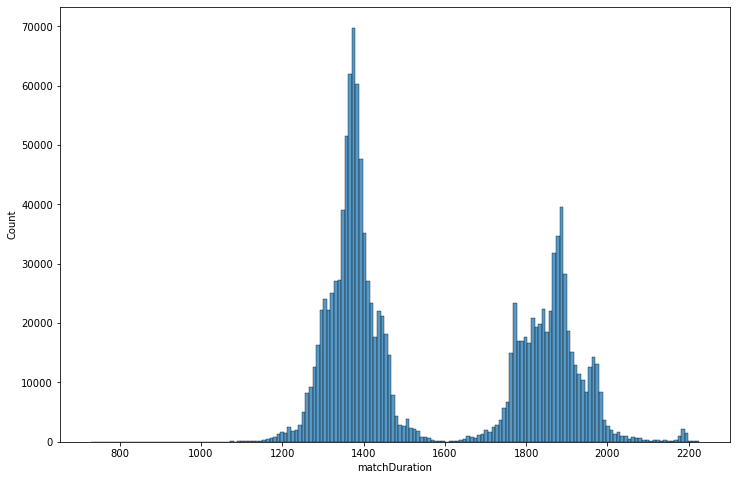

In [71]:
plt.figure(figsize=(12,8))
sns.histplot(data=team_df , x='matchDuration')
plt.show()

In [72]:
# 4(km) X 4(km) : 0 , 8(km) X 8(km) : 1

team_df['maptype'] = team_df['matchDuration'].apply(lambda x : 0 if x<1600 else 1)

- matchDuration 사용 완료 제외

In [73]:
team_df = team_df.drop(columns='matchDuration')

In [74]:
team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']

winPlacePerc            1.000000
walkDistance            0.844499
boosts                  0.716719
weaponsAcquired         0.706871
damageDealt             0.546226
kills                   0.527081
longestKill             0.512686
heals                   0.507204
killStreaks             0.485215
DBNOs                   0.435345
assists                 0.424020
revives                 0.373445
headshotKills           0.367316
rideDistance            0.353155
swimDistance            0.166361
maptype                 0.004263
match_type_numerical    0.002131
maxPlace               -0.002380
team_members           -0.190388
killPlace              -0.811058
hack_user_team               NaN
hack_user_game               NaN
Name: winPlacePerc, dtype: float64

### 거리 관련 feature(walkDistance, rideDistance, swimDistance) 확인

#### swimdistance 확인

- 수영을 한 플레이어

In [75]:
team_df[team_df['swimDistance']>0]['winPlacePerc'].mean()

0.7152851445711693

- 수영을 하진 않은 플레이어

In [76]:
team_df[team_df['swimDistance']==0]['winPlacePerc'].mean()


0.47352594270746834

<Figure size 864x576 with 0 Axes>

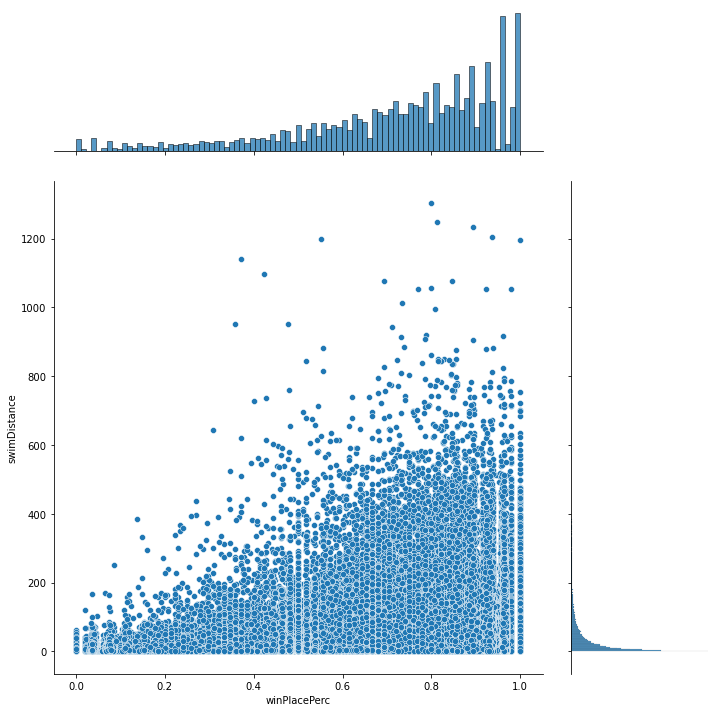

In [77]:
sns.jointplot(y='swimDistance', x ='winPlacePerc', data=team_df[team_df['swimDistance']>0], height=10, ratio=3)
plt.show()

- 맵 사이즈별 예측값 상관관계

In [78]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['swimDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['swimDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.000000,1.000000
swimDistance,0.208592,0.135464


- 큰 맵은 수영하게에는 강 간격이 너무 넓어서 수영을 하기가 힘든 것으로 보인다

    - 75% 이상이 0인 수치이나 승률이 높은 구간에 가중치를 더 줄 수 있는 수치로 보여 보류

#### rideDistance 확인

- 차량 이용한 플레이어

In [79]:

print('작은 맵 차량 이용안한 : ', team_df[(team_df.maptype == 0) & (team_df['rideDistance']==0)]['winPlacePerc'].mean())
print('작은 맵 차량 이용 : ', team_df[(team_df.maptype == 0) & (team_df['rideDistance']>0)]['winPlacePerc'].mean())

print('큰 맵 차량 이용안한 : ', team_df[(team_df.maptype == 1) & (team_df['rideDistance']==0)]['winPlacePerc'].mean())
print('큰 맵 차량 이용 : ', team_df[(team_df.maptype == 1) & (team_df['rideDistance']>0)]['winPlacePerc'].mean())


작은 맵 차량 이용안한 :  0.4464017710464243
작은 맵 차량 이용 :  0.7132472086249037
큰 맵 차량 이용안한 :  0.30687259637229225
큰 맵 차량 이용 :  0.6661220031353068


- 맵 사이즈별 예측값 상관관계

In [80]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['rideDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['rideDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.0000,1.000000
rideDistance,0.2635,0.543594


- 작은 맵

<Figure size 864x576 with 0 Axes>

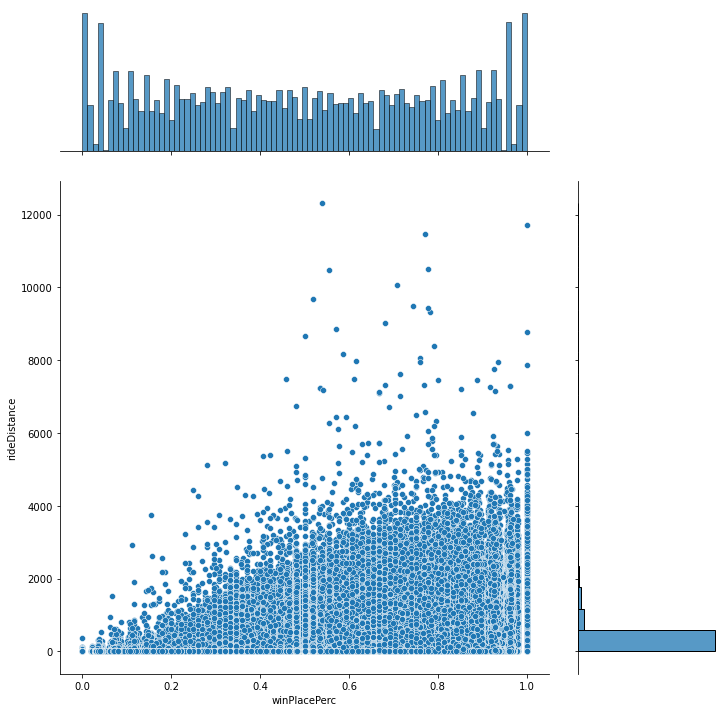

In [81]:
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=team_df[team_df.maptype==0], height=10, ratio=3)
plt.show()

- 큰 맵 

<Figure size 864x576 with 0 Axes>

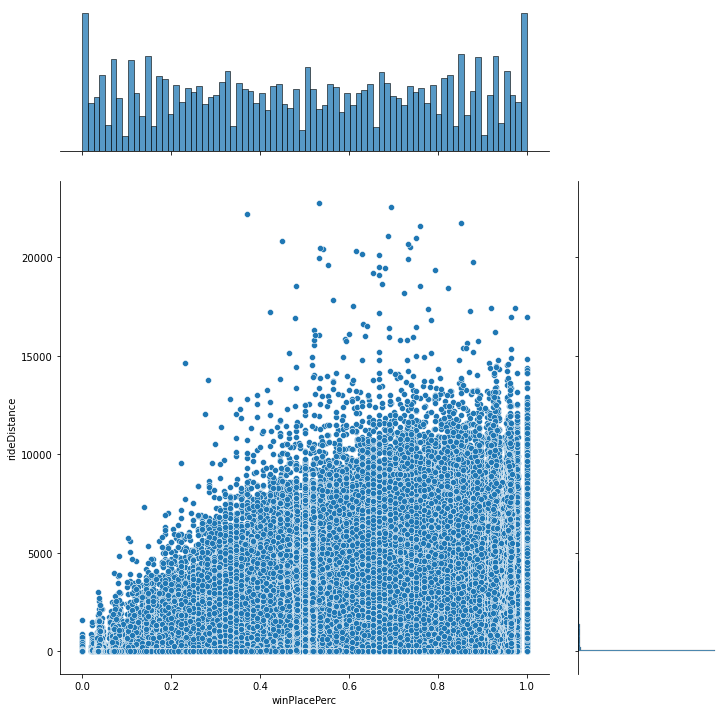

In [82]:
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=team_df[team_df.maptype==1], height=10, ratio=3)
plt.show()

    - 멥 사이즈에 따라 차량 이동 거리가 등수에 다른 영향을 주는 것을 확인 할 수 있다.

#### walkdistance 확인

<Figure size 864x576 with 0 Axes>

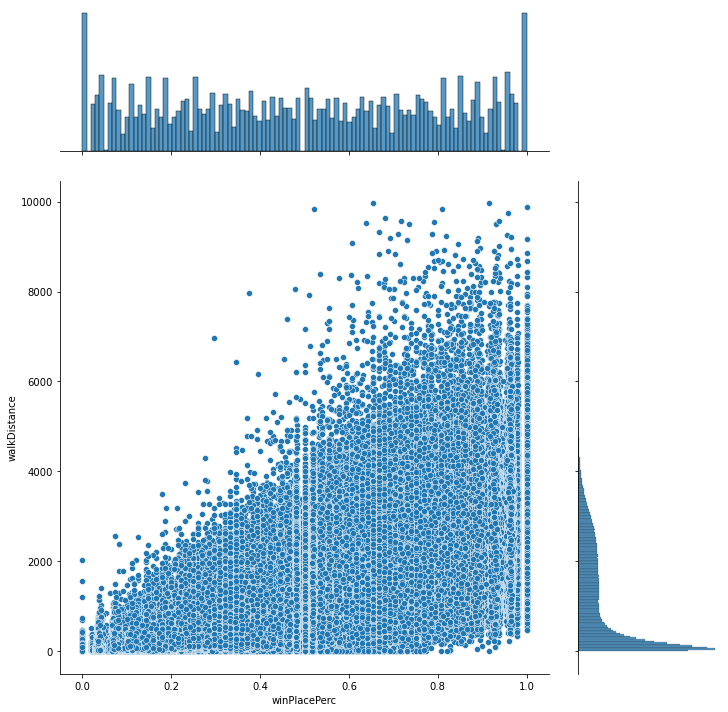

In [83]:
sns.jointplot(y='walkDistance', x ='winPlacePerc', data=team_df, height=10, ratio=3)
plt.show()

- 맵 사이즈별 예측값 상관관계

In [84]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['walkDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['walkDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.000000,1.000000
walkDistance,0.880691,0.836806


    - 작은 맵에서 조금 더 상관관계가 높음

### 아이템 관련 feature(boosts, heals, weaponsAcquired) 확인

In [85]:
team_df[['boosts', 'heals', 'weaponsAcquired']].describe()

,boosts,heals,weaponsAcquired
count,1.299387e+06,1.299387e+06,1.299387e+06
mean,1.211224e+00,1.514811e+00,3.792930e+00
std,1.550401e+00,2.333649e+00,1.937892e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,2.333333e+00
50%,5.000000e-01,5.000000e-01,3.666667e+00
75%,2.000000e+00,2.000000e+00,5.000000e+00
max,1.400000e+01,3.900000e+01,3.400000e+01


In [96]:
team_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr()


,boosts,heals,weaponsAcquired,winPlacePerc
boosts,1.000000,0.625576,0.535184,0.716719
heals,0.625576,1.000000,0.405440,0.507204
weaponsAcquired,0.535184,0.405440,1.000000,0.706871
winPlacePerc,0.716719,0.507204,0.706871,1.000000


#### boosts 확인

- boosts 사용한 플레이어

In [86]:
team_df[team_df['boosts']>0]['winPlacePerc'].mean()

0.6476126366117702

- boosts 사용 안한 플레이어

In [87]:
team_df[team_df['boosts']==0]['winPlacePerc'].mean()

0.2514254178042526

- 맵 사이즈별 예측값 상관관계

In [113]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['boosts', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['boosts', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.000000,1.000000
boosts,0.715375,0.726488


- boost 아이템 사용에 대한 등수 확인

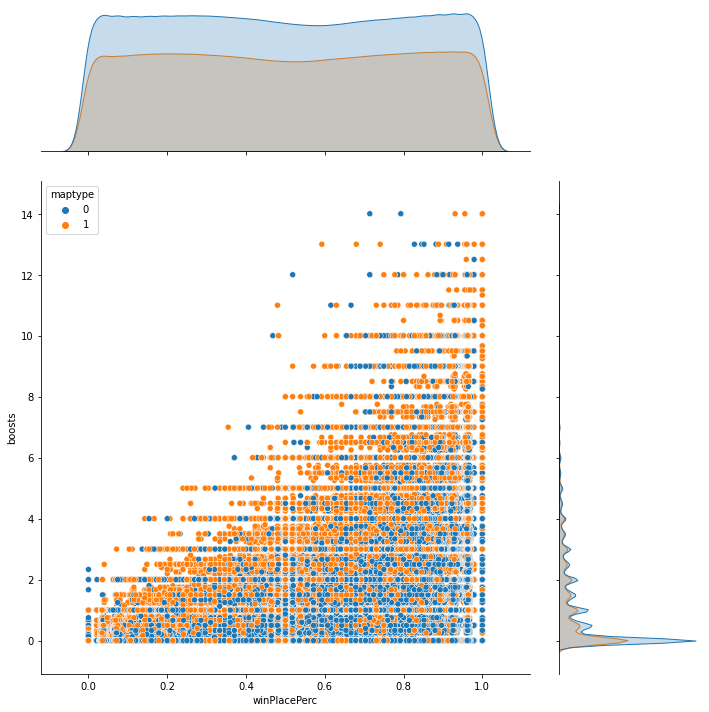

In [112]:
sns.jointplot(y='boosts', x ='winPlacePerc', hue='maptype' , data=team_df, height=10, ratio=3)
plt.show()

- 사용 유무에 따라 많은 등수 차이 예상
- 등수와 높은 상관관계를 확인


#### heals 확인

- heals 사용한 플레이어

In [97]:
team_df[team_df['heals']>0]['winPlacePerc'].mean()

0.6340806293272452

- heals 사용 안한 플레이어

In [98]:
team_df[team_df['heals']==0]['winPlacePerc'].mean()

0.2815295302231039

- 맵 사이즈별 예측값 상관관계

In [122]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['heals', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['heals', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.000000,1.000000
heals,0.516642,0.523401


- heal 아이템 사용에 대한 등수 확인

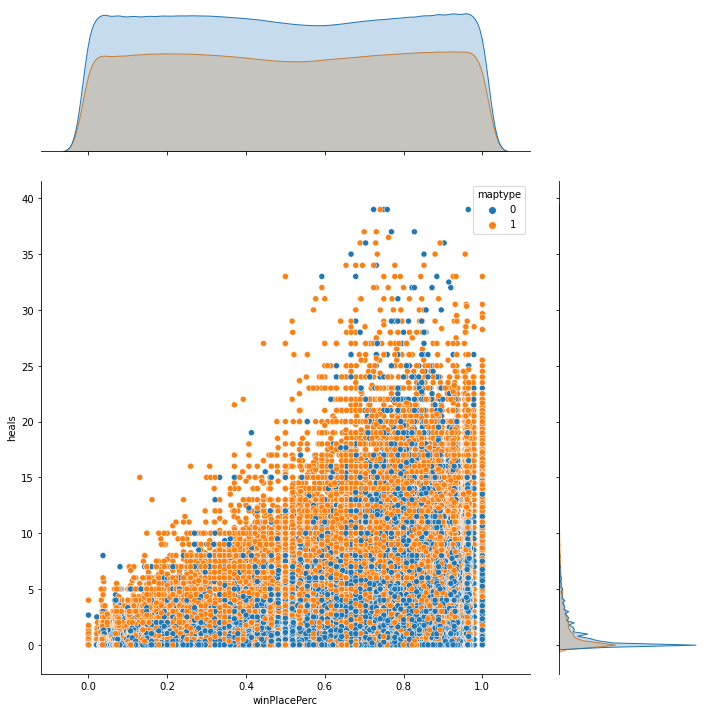

In [115]:
sns.jointplot(y='heals', x ='winPlacePerc', hue='maptype', data=team_df, height=10, ratio=3)
plt.show()

- 사용 유무에 따라 많은 등수 차이 예상
- 등수와 높은 상관관계를 확인


#### 무기획득(weaponsAcquired) 확인

- 무기획득(weaponsAcquired)한 플레이어

In [120]:
team_df[team_df['weaponsAcquired']>0]['winPlacePerc'].mean()

0.5028069620571755

- 무기획득(weaponsAcquired) 못한 플레이어

In [119]:
team_df[team_df['weaponsAcquired']==0]['winPlacePerc'].mean()

0.08439354480375216

- 맵 사이즈별 예측값 상관관계

In [123]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

,small_map,large_map
winPlacePerc,1.00000,1.000000
weaponsAcquired,0.72992,0.720303


- 무기획득(weaponsAcquired)에 대한 등수 확인

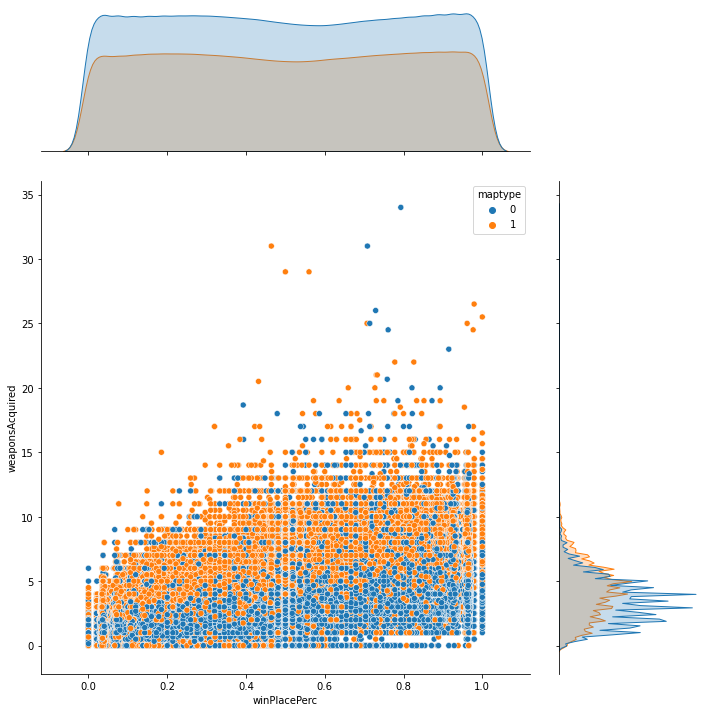

In [121]:
sns.jointplot(y='weaponsAcquired', x ='winPlacePerc', hue='maptype', data=team_df, height=10, ratio=3)
plt.show()

- 획득하지 못한 경우 최하위권 예상
- 등수와 높은 상관관계를 확인


#### 아이템들간의 상관 관계 확인

- heals, boosts 관계 확인

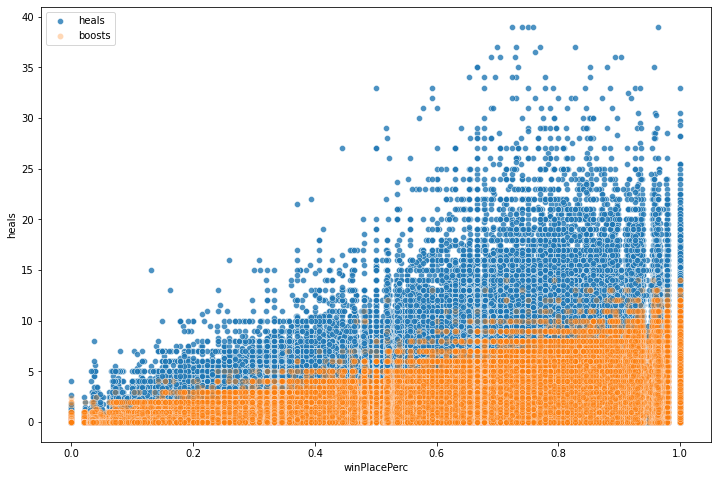

In [110]:
plt.figure(figsize=(12, 8))
g0 = sns.scatterplot(x='winPlacePerc', y='heals', data=team_df, alpha=0.8, label='heals')
g1 = sns.scatterplot(x='winPlacePerc', y='boosts', data=team_df, alpha=0.3, label='boosts')
# g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=team_df, alpha=0.3, label='weaponsAcquired')


    - heals와 boost는 관계성이 있어 보임

- heals와 boosts를 합친 feature 생성 후 등수와의 관계 확인

In [126]:
team_df['items'] = team_df.heals + team_df.boosts

In [127]:
team_df[['boosts', 'heals', 'items', 'winPlacePerc']].corr()

,boosts,heals,items,winPlacePerc
boosts,1.000000,0.625576,0.855674,0.716719
heals,0.625576,1.000000,0.939035,0.507204
items,0.855674,0.939035,1.000000,0.652310
winPlacePerc,0.716719,0.507204,0.652310,1.000000


- heals, boosts, weaponsAcquired 각각의 관계 확인

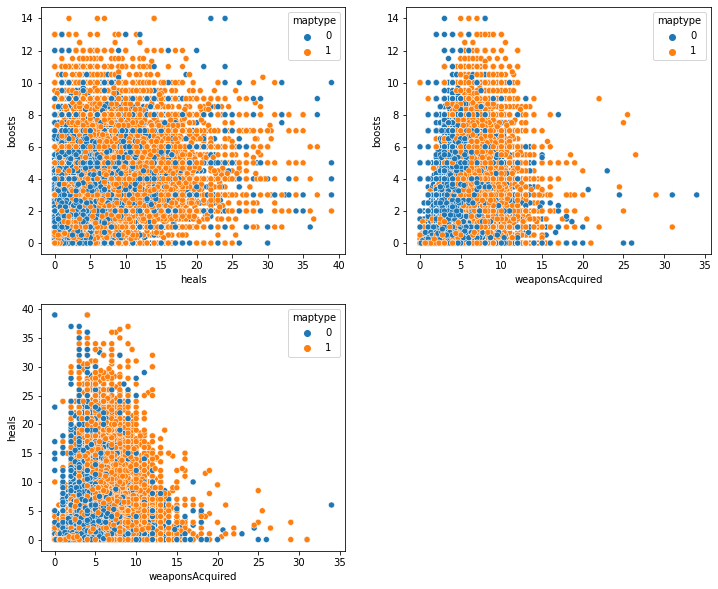

In [118]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='heals', y='boosts', data=team_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=team_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='weaponsAcquired', y='heals', data=team_df, alpha=0.5, hue='maptype')
plt.show()


### Kill 관련 feature(kills, longestkill, killstreaks, headshotkills) 확인

In [89]:
team_df[['kills', 'longestKill', 'killStreaks', 'headshotKills']].describe()


,kills,longestKill,killStreaks,headshotKills
count,1.299387e+06,1.299387e+06,1.299387e+06,1.299387e+06
mean,9.755212e-01,2.450860e+01,5.872758e-01,2.356189e-01
std,1.223257e+00,4.102364e+01,5.601226e-01,4.359968e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e-01,7.200000e+00,5.000000e-01,0.000000e+00
75%,1.500000e+00,3.086500e+01,1.000000e+00,3.333333e-01
max,2.000000e+01,9.605500e+02,9.000000e+00,1.300000e+01


### 나머지 feature(damageDealt, DBNOs, assists, revives) 확인

## solo game 확인 

In [90]:
solo_df = hack_fuature_add_df[hack_fuature_add_df.match_type_numerical == 0].copy()

### solo game groupid 중복 확인

In [91]:
solo_df['team_members'].value_counts()

1     650284
2      27268
3       4299
4       1456
5        545
16       368
18       342
17       289
6        186
19       171
15       165
14       126
8        120
13       104
7         84
10        70
11        66
64        64
12        48
9         45
20        20
Name: team_members, dtype: int64

- 5명 이상이 동일 등수 경기수

In [92]:
solo_df[(solo_df.match_type_numerical == 0)& (solo_df.team_members>=5)]['matchId'].nunique()

286

- solo 전체 경기수

In [93]:
solo_df[solo_df.match_type_numerical == 0].matchId.nunique()

7337

- 경기 비중도 적고 solo 경기에 5명이상이 같은 등수를 가지는 것은 일반적이지 않다고 판단

In [94]:
solo_df = solo_df.drop(index=solo_df[solo_df.team_members>=5].index).copy()

    - solo 동일 등수 인원 5명 이상인 경기 제외